## Overview

Unlike the method explained in notebook(4.1), here we directly simulate the time evolution of 40 compartments. To do that, we divide the computational domain $[0, L]$ into $K=40$ compartments of length $h=L / K=25 \mu \mathrm{m} .$ We denote the number of molecules of chemical species $A$ in the $i$ th compartment $[(i-1) h, i h)$ by $A_{i}, i=1,2, \ldots, K$ As a result of Brownian motion, molecules jump between neighbouring compartments. Thus we model diffusion as the following chain of “**chemical reactions**":

$$
A_1 \overset{d}{\underset{d}\leftrightarrow} A_2 \overset{d}{\underset{d}\leftrightarrow} A_3 \overset{d}{\underset{d}\leftrightarrow}\dots \overset{d}{\underset{d}\leftrightarrow} A_k
$$

where, as usual,
$$
A_i \overset{d}{\leftrightarrow} A_{i+1} 
$$
and
$$
A_{i+1} \overset{d}{\leftrightarrow} A_{i} 
$$

## SSA algorithm

Now **The system of chemical reactions can be simulated by the Gillespie SSA, provided that the rate constant d:**

$$
d=\frac{D}{h^{2}}
$$

where $D$ is the diffusion constant and $h$ is the compartment length. The propensities are:
$$
\alpha_{i}(t) \equiv A_{i}(t) d=A_{i}(t) \frac{D}{h^{2}}, \quad \text { for } i=1,2, \ldots, K
$$

Because we have $2K-2$ "reactions", the total propensity is:

$$
\alpha_{0}=\sum_{i=1}^{K-1} \alpha_{i}(t)+\sum_{i=2}^{K} \alpha_{i}(t)\text{---(1)}
$$

No matter how the next reaction proceeds, whether it jumps to the right or it jumps to the left, **there are only two compartments for which the number of molecules changes.** More over, the eqn.(1) can be simplified as:

$$
\begin{aligned} \alpha_{0} &=\sum_{i=1}^{K-1} \alpha_{i}(t)+\sum_{i=2}^{K} \alpha_{i}(t)=2\left(\sum_{i=1}^{K} \alpha_{i}(t)\right)-\alpha_{1}(t)-\alpha_{K}(t) \\ &=2 d\left(\sum_{i=1}^{K} A_{i}(t)\right)-\alpha_{1}(t)-\alpha_{K}(t)=2 d N-\alpha_{1}(t)-\alpha_{K}(t) \end{aligned}
$$

where N is the total number of molecules in the simulation (this number is conserved because there is no creation or degradation of the molecules in the system). system). In particular, **we need to recompute $\alpha_{0}$ only when there is a change in $\alpha_{1}(t)$ or $\alpha_{K}(t),$** Taking effects above into account, we now reformulate the SSA as:

1. Generate two random numbers $r_{1}, r_{2}$ uniformly distributed in $(0,1) .$

2. Compute propensity functions of reactions $\alpha_{i}(t)$ and $\alpha_{0}$

3. Compute the time at which the next chemical reaction takes place as $t+\tau$ 

4. If $r_{2}<\sum_{i=1}^{K-1} \alpha_{i} / \alpha_{0},$ then find $j \in\{1,2, \ldots, K-1\}$ such that

$$
r_{2} \geq \frac{1}{\alpha_{0}} \sum_{i=1}^{j-1} \alpha_{i} \quad \text { and } \quad r_{2}<\frac{1}{\alpha_{0}} \sum_{i=1}^{j} \alpha_{i}
$$

to do:
$$
\begin{aligned} A_{j}(t+\tau) &=A_{j}(t)-1 \\ A_{j+1}(t+\tau) &=A_{j+1}(t)+1 \\ A_{i}(t+\tau) &=A_{i}(t), \quad \text { for } i \neq j, i \neq j+1 \end{aligned}
$$

5. If $r_{2} \geq \sum_{i=1}^{K-1} \alpha_{i} / \alpha_{0},$ then find $j \in\{2,3, \ldots, K\}$ such that

$$
r_{2} \geq \frac{1}{\alpha_{0}}\left(\sum_{i=1}^{K-1} \alpha_{i}+\sum_{i=2}^{j-1} \alpha_{i}\right) \quad \text { and } \quad r_{2}<\frac{1}{\alpha_{0}}\left(\sum_{i=1}^{K-1} \alpha_{i}+\sum_{i=2}^{j} \alpha_{i}\right)
$$

to do:
$$
\begin{aligned} A_{j}(t+\tau) &=A_{j}(t)-1 \\ A_{j-1}(t+\tau) &=A_{j-1}(t)+1 \\ A_{i}(t+\tau) &=A_{i}(t), \quad \text { for } i \neq j, i \neq j-1 \end{aligned}
$$

6. Return to 1 and repeat

Let's implement this algorithm below

In [43]:
import numpy as np
from numpy.random import uniform

def compartment(nc,x0,ntot,d,ttot):
    t = 0
    alst = np.zeros(nc,dtype=int)
    alst[x0]=ntot//len(x0)
    fw = d*alst[:-1]
    bk = d*alst[1:]
    
    while t<ttot:
        
        a0 = np.sum(fw)+np.sum(bk)
        r1,r2 = uniform(size=2)
        t += 1/a0*np.log(1/r1)
        plst = np.cumsum(fw.tolist()+bk.tolist())/a0
        i = int(np.sum(plst<r2))
  
        if i<=nc-2 and alst[i]>0:
            alst[i]-=1
            alst[i+1]+=1
        elif alst[i-nc+2]>0:
            alst[i-nc+2]-=1
            alst[i-nc+1]+=1
                
        fw = d*alst[:-1]
        bk = d*alst[1:]
        
    return alst

In [44]:
import numpy as np

D_h2 = 0.16
X0=[16,17]
N = 1000
T = 240
Nc = 40
As = compartment(Nc,X0,N,D_h2,T)

Text(0, 0.5, 'count')

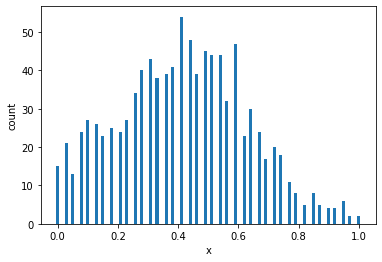

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.ticklabel_format(useOffset=False)
xs = np.round(np.linspace(0,1,Nc),2)
plt.bar(xs,As.tolist(),width=0.01)
plt.xlabel('x')
plt.ylabel('count')